# ImageCAS dataset EDA

## 1. Check data

In [246]:
import autorootcwd
import os
import nibabel as nib
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [36]:
base_path = "data/imageCAS"

### Check data location and Count data

In [37]:
def check_missing_files(base_path):
    directories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    total_dirs = len(directories)
    
    print(f"\nTotal patient directory count: {total_dirs}")

    missing_patients = []
    
    for dir_name in tqdm(directories, desc="Checking missing files"):
        dir_path = os.path.join(base_path, dir_name)
        img_exists = os.path.exists(os.path.join(dir_path, 'img.nii.gz'))
        label_exists = os.path.exists(os.path.join(dir_path, 'label.nii.gz'))
        
        if not (img_exists and label_exists):
            missing_files = []
            if not img_exists: missing_files.append('img.nii.gz')
            if not label_exists: missing_files.append('label.nii.gz')
            missing_patients.append((dir_name, missing_files))
    
    if missing_patients:
        print("\nPatients with missing files:")
        for patient_id, missing_files in missing_patients:
            print(f"Patient {patient_id}: {', '.join(missing_files)} missing")
    else:
        print("\nAll patient data have img.nii.gz and label.nii.gz files.")

check_missing_files(base_path)


Total patient directory count: 1000


Checking missing files: 100%|██████████| 1000/1000 [00:00<00:00, 21739.24it/s]


All patient data have img.nii.gz and label.nii.gz files.


### Get nifTi file metadata

In [42]:
data_number = 1
nii = nib.load("data/imageCAS/{}/img.nii.gz".format(data_number))

output_dir = "nbs/result/eda/"
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, "imageCAS_nifti_header_info.txt")

with open(output_file, 'w') as f:

    f.write("=== NIfTI Header Info [{}]===\n\n".format(data_number))
    
    f.write(str(nii.header))
    f.write("\n\n=== Detailed Header Info ===\n\n")
    
    for field in nii.header:
        f.write(f"{field}: {nii.header[field]}\n")
    
    f.write("\n=== Additional Info ===\n")
    f.write(f"data type: {nii.get_data_dtype()}\n")
    f.write(f"image size: {nii.shape}\n")
    f.write(f"header size: {nii.header.sizeof_hdr} bytes\n")

print(f"header info is saved in {output_file}")

header info is saved in src/eda/imageCAS_nifti_header_info.txt


### Check shape and voxel size of the image and label match

In [34]:
def check_match_img_and_label(base_path):
    results = []
    
    for i in tqdm(range(1, 1001)):
        folder = str(i)
        folder_path = os.path.join(base_path, folder)
        
        if not os.path.exists(folder_path):
            continue
            
        try:
            img_path = os.path.join(folder_path, 'img.nii.gz')
            label_path = os.path.join(folder_path, 'label.nii.gz')
            
            # image file analysis
            if os.path.exists(img_path):
                img_nii = nib.load(img_path)
                img_shape = img_nii.shape
                img_voxel = img_nii.header.get_zooms()
            else:
                img_shape = None
                img_voxel = None
                
            # label file analysis
            if os.path.exists(label_path):
                label_nii = nib.load(label_path)
                label_shape = label_nii.shape
                label_voxel = label_nii.header.get_zooms()
            else:
                label_shape = None
                label_voxel = None
                
            results.append({
                'folder': i,
                'img_shape': img_shape,
                'img_voxel_size': img_voxel,
                'label_shape': label_shape,
                'label_voxel_size': label_voxel
            })
            
        except Exception as e:
            print(f"[Error] Patient id {i}: {str(e)}")
            
    return pd.DataFrame(results)

In [43]:
df = check_match_img_and_label(base_path)

df.to_csv('nbs/result/eda/nifti_analysis_results.csv', index=False)

print("\n=== Analysis Results ===")
print("\nUnique image shape:")
print(df['img_shape'].value_counts())

print("\nUnique image voxel size:")
print(df['img_voxel_size'].value_counts())

mismatched_shape = df[df['img_shape'] != df['label_shape']]
if not mismatched_shape.empty:
    print("\nCases where image and label shape do not match:")
    print(mismatched_shape[['folder', 'img_shape', 'label_shape']])
else:
    print("\nAll image and label shapes match.")

mismatched_voxel = df[df['img_voxel_size'] != df['label_voxel_size']]
if not mismatched_voxel.empty:
    print("\nCases where image and label voxel size do not match:")
    print(mismatched_voxel[['folder', 'img_voxel_size', 'label_voxel_size']])
else:
    print("\nAll image and label voxel sizes match.")

# check missing files
missing = df[df['img_shape'].isna() | df['label_shape'].isna()]
if not missing.empty:
    print("\nFolders with missing files:")
    print(missing['folder'].tolist())

100%|██████████| 1000/1000 [00:01<00:00, 990.68it/s]


=== Analysis Results ===

Unique image shape:
img_shape
(512, 512, 275)    621
(512, 512, 206)    126
(512, 512, 245)     18
(512, 512, 259)     15
(512, 512, 241)     15
(512, 512, 229)     13
(512, 512, 223)     13
(512, 512, 249)     12
(512, 512, 243)     12
(512, 512, 239)     12
(512, 512, 247)     11
(512, 512, 261)     11
(512, 512, 221)     10
(512, 512, 253)     10
(512, 512, 231)     10
(512, 512, 233)      9
(512, 512, 225)      9
(512, 512, 257)      8
(512, 512, 227)      8
(512, 512, 237)      7
(512, 512, 255)      6
(512, 512, 219)      6
(512, 512, 263)      6
(512, 512, 235)      6
(512, 512, 251)      4
(512, 512, 217)      4
(512, 512, 209)      2
(512, 512, 248)      2
(512, 512, 267)      2
(512, 512, 228)      1
(512, 512, 215)      1
(512, 512, 187)      1
(512, 512, 240)      1
(512, 512, 213)      1
(512, 512, 236)      1
(512, 512, 166)      1
(512, 512, 269)      1
(512, 512, 277)      1
(512, 512, 265)      1
(512, 512, 268)      1
(512, 512, 200)      1


### Check the voxel size and image shape for each data

In [33]:
def analyze_voxel_size_and_image_shape(base_path):
    results = []
    
    for i in tqdm(range(1, 1001)):
        folder = str(i)
        img_path = os.path.join(base_path, folder, 'img.nii.gz')
        
        if not os.path.exists(img_path):
            continue
            
        try:
            img_nii = nib.load(img_path)
            voxel_size = img_nii.header.get_zooms()
            shape = img_nii.shape
            
            results.append({
                'patient_id': i,
                'voxel_x': voxel_size[0],
                'voxel_y': voxel_size[1],
                'voxel_z': voxel_size[2],
                'shape_x': shape[0],
                'shape_y': shape[1],
                'shape_z': shape[2]
            })
            
        except Exception as e:
            print(f"[Error] Patient id {i}: {str(e)}")
    
    return pd.DataFrame(results)


Voxel Spacing

In [45]:
df = analyze_voxel_size_and_image_shape(base_path)

print("\n=== Voxel Size Statistics ===")
stats = df[['voxel_x', 'voxel_y', 'voxel_z']].describe()
print(stats)

# unique voxel size
unique_voxels = df.groupby(['voxel_x', 'voxel_y', 'voxel_z']).size().reset_index(name='count')
unique_voxels = unique_voxels.sort_values('count', ascending=False)
print("\n=== Unique Voxel Size Combination ===")
print(unique_voxels)

df.to_csv('nbs/result/eda/voxel_size_comparison.csv', index=False)

# check outliers (cases more than 2 standard deviations from the mean)
print("\n=== Check Outliers ===")
for col in ['voxel_x', 'voxel_y', 'voxel_z']:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[abs(df[col] - mean) > 2*std]
    if not outliers.empty:
        print(f"\n{col} outliers:")
        print(outliers[['patient_id', col]])

100%|██████████| 1000/1000 [00:00<00:00, 1888.08it/s]


=== Voxel Size Statistics ===
           voxel_x      voxel_y  voxel_z
count  1000.000000  1000.000000   1000.0
mean      0.352982     0.352982      0.5
std       0.029897     0.029897      0.0
min       0.289062     0.289062      0.5
25%       0.320312     0.320312      0.5
50%       0.349609     0.349609      0.5
75%       0.371582     0.371582      0.5
max       0.464844     0.464844      0.5

=== Unique Voxel Size Combination ===
     voxel_x   voxel_y  voxel_z  count
6   0.318359  0.318359      0.5    240
20  0.345703  0.345703      0.5     35
28  0.361328  0.361328      0.5     33
18  0.341797  0.341797      0.5     29
19  0.343750  0.343750      0.5     29
..       ...       ...      ...    ...
59  0.421875  0.421875      0.5      1
67  0.445312  0.445312      0.5      1
66  0.435547  0.435547      0.5      1
70  0.453125  0.453125      0.5      1
71  0.458984  0.458984      0.5      1

[73 rows x 4 columns]

=== Check Outliers ===

voxel_x outliers:
     patient_id   voxel_x
1

Image Shape

In [46]:
df = analyze_voxel_size_and_image_shape(base_path)

print("\n=== Image Shape Statistics ===")
stats = df[['shape_x', 'shape_y', 'shape_z']].describe()
print(stats)

#unique image shape
unique_shapes = df.groupby(['shape_x', 'shape_y', 'shape_z']).size().reset_index(name='count')
unique_shapes = unique_shapes.sort_values('count', ascending=False)
print("\n=== Unique Image Shape Combination ===")
print(unique_shapes)

df.to_csv('nbs/result/eda/image_shape_comparison.csv', index=False)

# check outliers (cases more than 2 standard deviations from the mean)
print("\n=== Check Outliers ===")
for col in ['shape_x', 'shape_y', 'shape_z']:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[abs(df[col] - mean) > 2*std]
    if not outliers.empty:
        print(f"\n{col} outliers:")
        print(outliers[['patient_id', col]])

100%|██████████| 1000/1000 [00:00<00:00, 1924.91it/s]


=== Image Shape Statistics ===
       shape_x  shape_y      shape_z
count   1000.0   1000.0  1000.000000
mean     512.0    512.0   257.496000
std        0.0      0.0    25.678227
min      512.0    512.0   166.000000
25%      512.0    512.0   241.000000
50%      512.0    512.0   275.000000
75%      512.0    512.0   275.000000
max      512.0    512.0   277.000000

=== Unique Image Shape Combination ===
    shape_x  shape_y  shape_z  count
39      512      512      275    621
3       512      512      206    126
24      512      512      245     18
22      512      512      241     15
32      512      512      259     15
14      512      512      229     13
10      512      512      223     13
20      512      512      239     12
23      512      512      243     12
27      512      512      249     12
25      512      512      247     11
33      512      512      261     11
29      512      512      253     10
15      512      512      231     10
9       512      512      221     10
11 

### Check Intensity

In [67]:
def visualize_hu_distribution(base_path="data/imageCAS", n_samples=10):
    train_dir = os.path.join(base_path, "train")
    cases = sorted(os.listdir(train_dir))
    
    # random sampling
    random.seed(42)
    selected_cases = random.sample(cases, n_samples)
    
    all_intensities = []
    
    print(f"Analyzing {n_samples} random cases...")
    
    for case in tqdm(selected_cases, desc="Processing cases"):
        img_path = os.path.join(train_dir, case, "img.nii.gz")
        label_path = os.path.join(train_dir, case, "label.nii.gz")
        
        img_nifti = nib.load(img_path)
        label_nifti = nib.load(label_path)
        
        image = img_nifti.get_fdata()
        label = label_nifti.get_fdata()
        
        # coronary artery mask
        vessel_mask = label > 0
        vessel_intensities = image[vessel_mask]
        
        all_intensities.extend(vessel_intensities.flatten())
        
    mean_val = np.mean(all_intensities)
    std_val = np.std(all_intensities)
    median_val = np.median(all_intensities)

    plt.figure(figsize=(15, 6))
    
    n, bins, patches = plt.hist(all_intensities, 
                              bins=100,
                              density=True, 
                              alpha=0.3, 
                              color='r')
    
    plt.axvline(mean_val, color='b', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.1f}')
    
    plt.xticks(np.arange(int(min(all_intensities)), int(max(all_intensities)), 50))  # 50 HU 
    plt.tick_params(axis='x', rotation=45)
    
    plt.grid(True, which='major', alpha=0.5, linestyle='-')
    plt.grid(True, which='minor', alpha=0.2, linestyle='--')
    
    plt.title(f'Distribution of HU Values in Coronary Arteries\n(from {n_samples} random cases)')
    plt.xlabel('HU Value')
    plt.ylabel('Density')
    plt.legend()
    
    plt.tight_layout()
    
    print("\nOverall Statistics:")
    print(f"Mean HU: {mean_val:.2f} ± {std_val:.2f}")
    print(f"Median HU: {median_val:.2f}")
    print(f"Range: [{min(all_intensities):.2f}, {max(all_intensities):.2f}]")
    print(f"Total voxels analyzed: {len(all_intensities)}")
    
    plt.show()
    
    return {
        'intensities': all_intensities,
        'mean': mean_val,
        'std': std_val,
        'median': median_val,
        'selected_cases': selected_cases
    }

Analyzing 100 random cases...


Processing cases: 100%|██████████| 100/100 [10:40<00:00,  6.40s/it]



Overall Statistics:
Mean HU: 142.12 ± 179.55
Median HU: 106.43
Range: [-941.26, 3059.91]
Total voxels analyzed: 11223256


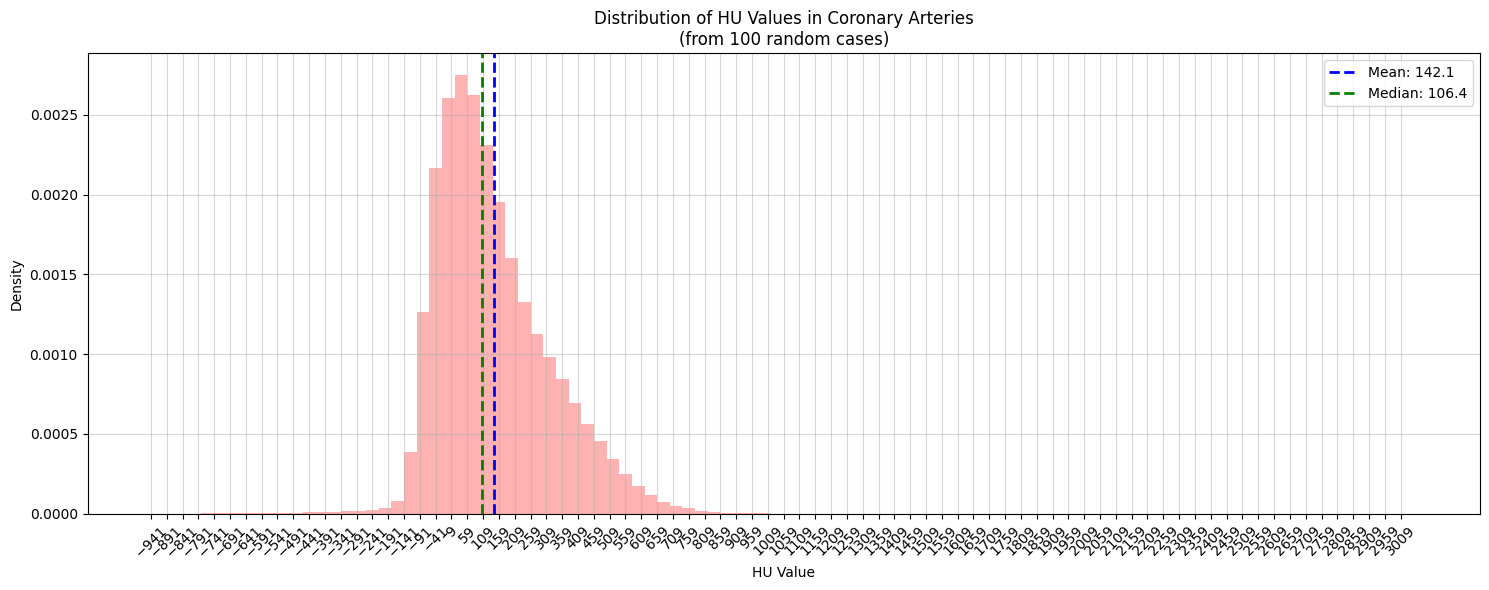

In [69]:
base_path = "data/imageCAS"

results = visualize_hu_distribution(base_path, n_samples=100)

## Data Preprocessing

In [3]:
import os
import gc
import nibabel as nib
import numpy as np
from scipy import ndimage
from tqdm import tqdm
from monai.transforms import Resize
import multiprocessing as mp
from functools import partial

In [2]:
import autorootcwd

base_path = "data/imageCAS"

1. Adjust voxel size and image shape

In [47]:
def preprocess_imageCAS(base_path, output_base="D:/imageCAS_preprocessed", target_spacing=(0.35, 0.35, 0.5), target_xy_size=512, check_interval=100):
    os.makedirs(output_base, exist_ok=True)
    
    directories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    total_dirs = len(directories)
    
    print(f"\nTotal patient directory count: {total_dirs}")
    print(f"Target voxel spacing: {target_spacing}")
    print(f"Target x,y size: {target_xy_size}")
    print(f"Output directory: {output_base}")
    
    errors = []
    skipped = []
    processed = []
    
    def print_interim_results(current_count):
        print(f"\n=== Interim Results (Processed directories: {current_count}/{total_dirs}) ===")
        print(f"Processed: {len(processed)} files")
        print(f"Skipped: {len(skipped)} files")
        print(f"Errors: {len(errors)} files")
        if errors:
            print("\nRecent errors:")
            for error in errors[-5:]:
                print(error)
        print("="*50)

    def resample_image(image, current_spacing, target_spacing, affine, is_label=False):
        try:
            image = image.astype(np.float32)
            scale_factors = np.array(current_spacing) / np.array(target_spacing)
            
            order = 0 if is_label else 1
            resampled_image = ndimage.zoom(image, scale_factors, order=order)
            
            scaling_matrix = np.diag(1 / scale_factors)
            new_affine = affine.copy()
            new_affine[:3, :3] = affine[:3, :3] @ scaling_matrix[:3, :3]
            
            return resampled_image, new_affine
        except Exception as e:
            raise Exception(f"[Error] Resampling failed: {str(e)}")

    for idx, dir_name in enumerate(tqdm(directories, desc="Data preprocessing")):
            input_dir_path = os.path.join(base_path, dir_name)
            output_dir_path = os.path.join(output_base, dir_name)
            os.makedirs(output_dir_path, exist_ok=True)
            
            for file_name in ['img.nii.gz', 'label.nii.gz']:
                input_file_path = os.path.join(input_dir_path, file_name)
                output_file_path = os.path.join(output_dir_path, file_name)
                is_label = file_name == 'label.nii.gz'

                if not os.path.exists(input_file_path):
                    errors.append(f"Patient {dir_name}: {file_name} file missing")
                    continue
                
                try:
                    nii = nib.load(input_file_path)
                    current_spacing = nii.header.get_zooms()
                    current_shape = nii.shape
                    
                    def is_close_enough(current, target, rtol=1e-5):
                        return np.allclose(current, target, rtol=rtol)

                    needs_processing = (
                        not is_close_enough(current_spacing, target_spacing) or 
                        current_shape[0] != target_xy_size or 
                        current_shape[1] != target_xy_size
                    )

                    if not needs_processing:
                        skipped.append(f"{dir_name}/{file_name}")
                        continue

                    image_data = nii.get_fdata(dtype=np.float32)
                    
                    resampled_image, new_affine = resample_image(
                        image_data, current_spacing, target_spacing, nii.affine, is_label
                    )

                    resize_mode = 'nearest' if is_label else 'bilinear'
                    resize_transform = Resize(
                        spatial_size=(target_xy_size, target_xy_size, resampled_image.shape[2]),
                        mode=resize_mode
                    )
                    resized_image = resize_transform(resampled_image[None])[0]
                    resized_image = resized_image.numpy()

                    if is_label:
                        resized_image = np.round(resized_image).astype(np.int32)

                    new_nii = nib.Nifti1Image(resized_image, affine=new_affine)
                    new_nii.header.set_zooms(target_spacing)
                    nib.save(new_nii, output_file_path)

                    processed.append(f"{dir_name}/{file_name}")

                    del nii, image_data, resampled_image, resized_image, new_nii
                    gc.collect()

                except Exception as e:
                    errors.append(f"Patient {dir_name}, {file_name} processing error: {str(e)}")
                    gc.collect()

            if (idx + 1) % check_interval == 0:
                print_interim_results(idx + 1)

    print("\n=== Final Results ===")
    print(f"Processed file count: {len(processed)}")
    print(f"Skipped file count: {len(skipped)}")
    print(f"Error count: {len(errors)}")
    if errors:
        print("Error files: ", errors)
    
    if errors:
        print("\nAll occurred errors:")
        for error in errors:
            print(error)

In [ ]:
target_spacing = (0.35, 0.35, 0.5)
target_xy_size = 512
base_path = "data/imageCAS"
output_base = "D:/imageCAS_preprocessed"

preprocess_imageCAS(base_path, output_base, target_spacing, target_xy_size, check_interval=200)


Total patient directory count: 1000
Target voxel spacing: (0.35, 0.35, 0.5)
Target x,y size: 512
Output directory: D:/imageCAS_preprocessed_f


Data preprocessing:   0%|          | 0/1000 [00:00<?, ?it/s]

Data preprocessing:  22%|██▏       | 220/1000 [00:00<00:02, 299.96it/s]


=== Interim Results (Processed directories: 200/1000) ===
Processed: 0 files
Skipped: 400 files
Errors: 0 files


Data preprocessing:  42%|████▏     | 422/1000 [00:01<00:03, 188.01it/s]


=== Interim Results (Processed directories: 400/1000) ===
Processed: 0 files
Skipped: 800 files
Errors: 0 files


Data preprocessing:  62%|██████▏   | 623/1000 [00:02<00:01, 193.99it/s]


=== Interim Results (Processed directories: 600/1000) ===
Processed: 0 files
Skipped: 1200 files
Errors: 0 files


Data preprocessing:  83%|████████▎ | 831/1000 [00:03<00:00, 188.32it/s]


=== Interim Results (Processed directories: 800/1000) ===
Processed: 0 files
Skipped: 1600 files
Errors: 0 files


Data preprocessing: 100%|██████████| 1000/1000 [00:04<00:00, 213.99it/s]


=== Interim Results (Processed directories: 1000/1000) ===
Processed: 0 files
Skipped: 2000 files
Errors: 0 files

=== Final Results ===
Processed file count: 0
Skipped file count: 2000
Error count: 0


Preprocessing voxel size, image shape result

In [43]:
df = analyze_voxel_size_and_image_shape(base_path)

print("\n=== Voxel Size Statistics ===")
stats = df[['voxel_x', 'voxel_y', 'voxel_z']].describe()
print(stats)

# unique voxel size
unique_voxels = df.groupby(['voxel_x', 'voxel_y', 'voxel_z']).size().reset_index(name='count')
unique_voxels = unique_voxels.sort_values('count', ascending=False)
print("\n=== Unique Voxel Size Combination ===")
print(unique_voxels)

df.to_csv('nbs/result/eda/voxel_size_comparison.csv', index=False)

# check outliers (cases more than 2 standard deviations from the mean)
if (unique_voxels.shape[0] > 1):
    print("\n=== Check Outliers ===")
    for col in ['voxel_x', 'voxel_y', 'voxel_z']:
        mean = df[col].mean()
        std = df[col].std()
    outliers = df[abs(df[col] - mean) > 2*std]
    if not outliers.empty:
        print(f"\n{col} outliers:")
        print(outliers[['patient_id', col]])

100%|██████████| 1000/1000 [00:00<00:00, 1900.64it/s]


=== Voxel Size Statistics ===
       voxel_x  voxel_y  voxel_z
count  1000.00  1000.00   1000.0
mean      0.35     0.35      0.5
std       0.00     0.00      0.0
min       0.35     0.35      0.5
25%       0.35     0.35      0.5
50%       0.35     0.35      0.5
75%       0.35     0.35      0.5
max       0.35     0.35      0.5

=== Unique Voxel Size Combination ===
   voxel_x  voxel_y  voxel_z  count
0     0.35     0.35      0.5   1000


In [44]:
df = analyze_voxel_size_and_image_shape(base_path)

print("\n=== Image Shape Statistics ===")
stats = df[['shape_x', 'shape_y', 'shape_z']].describe()
print(stats)

#unique image shape
unique_shapes = df.groupby(['shape_x', 'shape_y', 'shape_z']).size().reset_index(name='count')
unique_shapes = unique_shapes.sort_values('count', ascending=False)
print("\n=== Unique Image Shape Combination ===")
print(unique_shapes)

df.to_csv('nbs/result/eda/image_shape_comparison.csv', index=False)

# check outliers (cases more than 2 standard deviations from the mean)
print("\n=== Check Outliers ===")
for col in ['shape_x', 'shape_y', 'shape_z']:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[abs(df[col] - mean) > 2*std]
    if not outliers.empty:
        print(f"\n{col} outliers:")
        print(outliers[['patient_id', col]])

100%|██████████| 1000/1000 [00:00<00:00, 1938.85it/s]


=== Image Shape Statistics ===
       shape_x  shape_y      shape_z
count   1000.0   1000.0  1000.000000
mean     512.0    512.0   257.496000
std        0.0      0.0    25.678227
min      512.0    512.0   166.000000
25%      512.0    512.0   241.000000
50%      512.0    512.0   275.000000
75%      512.0    512.0   275.000000
max      512.0    512.0   277.000000

=== Unique Image Shape Combination ===
    shape_x  shape_y  shape_z  count
39      512      512      275    621
3       512      512      206    126
24      512      512      245     18
22      512      512      241     15
32      512      512      259     15
10      512      512      223     13
14      512      512      229     13
20      512      512      239     12
27      512      512      249     12
23      512      512      243     12
25      512      512      247     11
33      512      512      261     11
15      512      512      231     10
29      512      512      253     10
9       512      512      221     10
16 

## Transforms in Dataloader

In [6]:
import autorootcwd
from monai.utils import first, set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandFlipd,
    CropForegroundd,
    Compose,
    Spacingd,
    AsDiscreted,
    GaussianSmoothd,
    Lambda,
)
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import SimpleITK as sitk
import os
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import random

In [75]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(
        #    keys=["image", "label"],
        #    pixdim=(0.35, 0.35, 0.5),
        #    mode=("bilinear", "nearest"),
        # ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-150,
            a_max=550,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=6,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(
        #    keys=["image", "label"],
        #    pixdim=(0.35, 0.35, 0.5),
        #    mode=("bilinear", "nearest"),
        # ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-150,
            a_max=550,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [76]:
def visualize_transforms(image_path, label_path, slice_idx=80, transform=train_transforms):
    """visualize the before/after transforms for a specific image."""
    
    data_dict = [{"image": image_path, "label": label_path}]
    
    basic_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
    ])
    
    basic_ds = Dataset(data=data_dict, transform=basic_transforms)
    full_ds = Dataset(data=data_dict, transform=transform)
    
    basic_data = first(DataLoader(basic_ds, batch_size=1))
    full_data = first(DataLoader(full_ds, batch_size=1))
    
    plt.figure("Transforms Visualization", (15, 10))
    
    # Original Image
    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    plt.imshow(basic_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    # Original Label
    plt.subplot(2, 2, 2)
    plt.title("Original Label")
    plt.imshow(basic_data["label"][0, 0, :, :, slice_idx])
    
    # Transformed Image
    plt.subplot(2, 2, 3)
    plt.title("Transformed Image")
    plt.imshow(full_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    # Transformed Label
    plt.subplot(2, 2, 4)
    plt.title("Transformed Label")
    plt.imshow(full_data["label"][0, 0, :, :, slice_idx])
    
    plt.tight_layout()
    plt.show()
    
    print("Original Image shape:", basic_data["image"].shape)
    print("Original Image value range:", 
          basic_data["image"].min().item(), "to", 
          basic_data["image"].max().item())
    
    print("\nTransformed Image shape:", full_data["image"].shape)
    print("Transformed Image value range:", 
          full_data["image"].min().item(), "to", 
          full_data["image"].max().item())


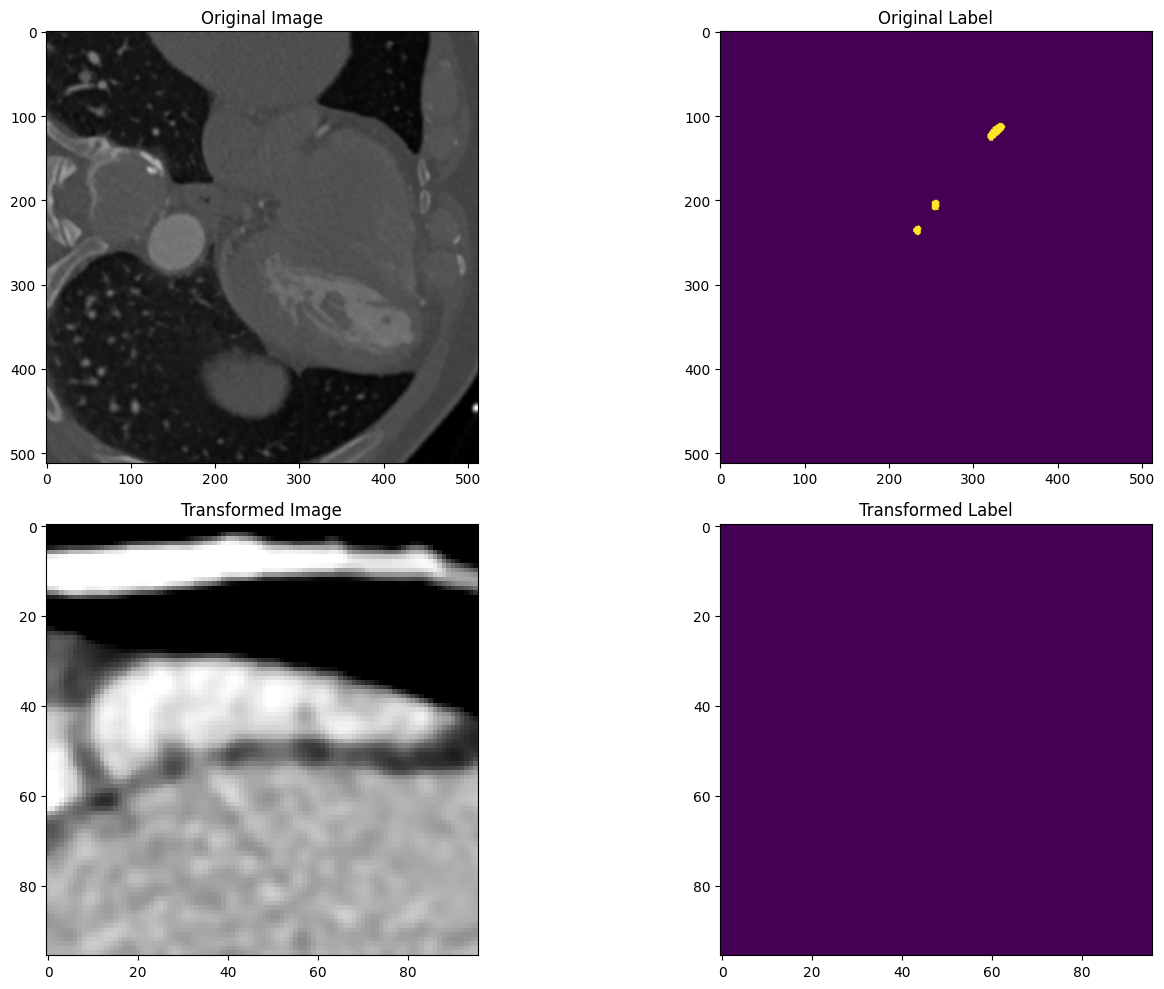

Original Image shape: torch.Size([1, 1, 512, 512, 275])
Original Image value range: -1024.0 to 2872.719970703125

Transformed Image shape: torch.Size([6, 1, 96, 96, 96])
Transformed Image value range: 0.0 to 1.0


In [78]:
case_dir = "data/imageCAS/train/10"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")

visualize_transforms(image_path, label_path, slice_idx=80, transform=train_transforms)

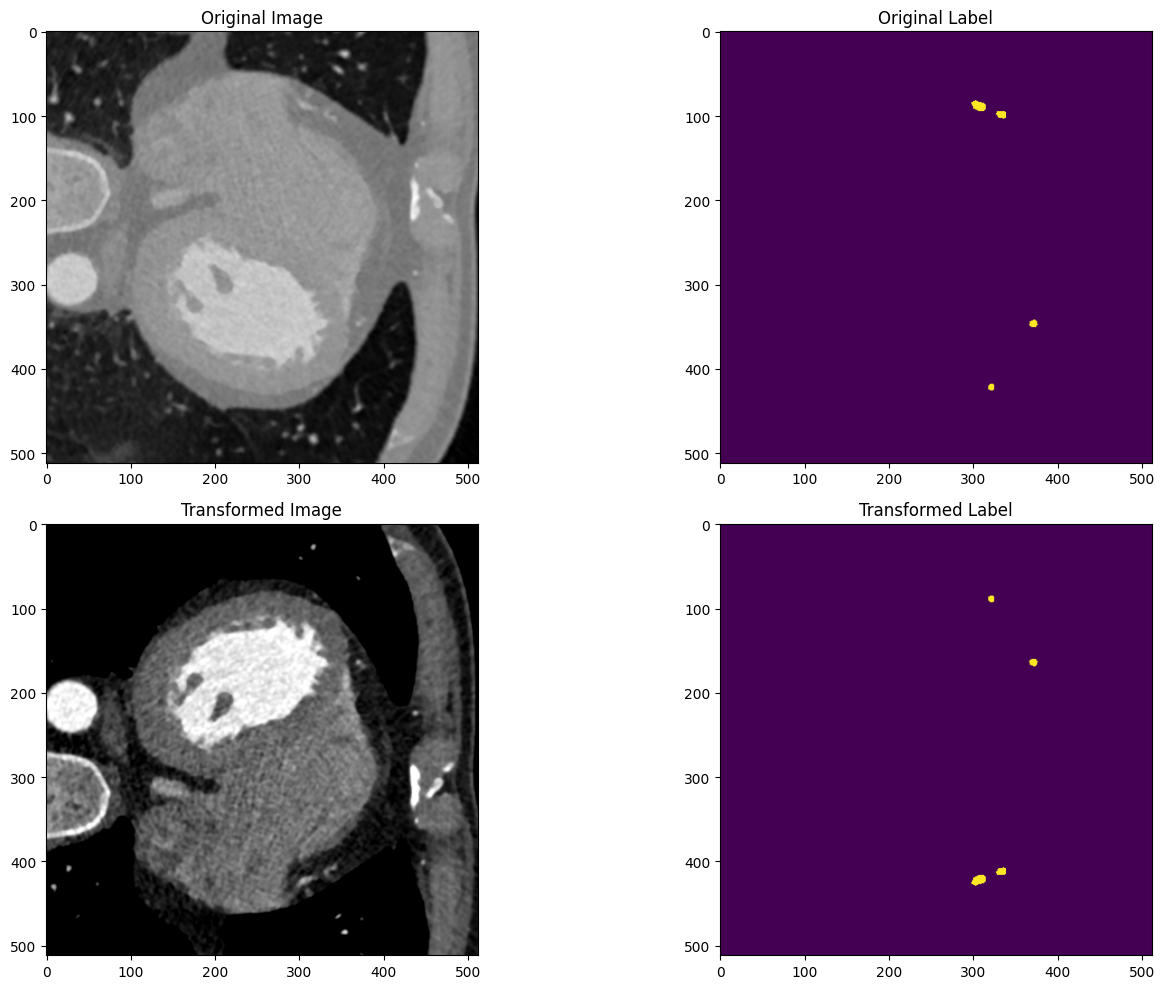

Original Image shape: torch.Size([1, 1, 512, 512, 219])
Original Image value range: -1024.0 to 1589.554443359375

Transformed Image shape: torch.Size([1, 1, 512, 512, 219])
Transformed Image value range: 0.0 to 1.0


In [79]:
case_dir = "data/imageCAS/valid/701"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")

visualize_transforms(image_path, label_path, slice_idx=80, transform=val_transforms)

## Transforms in Proposed Dataloader

In [142]:
use_distance_map = True
random.seed(42)

### Before Clipping

In [144]:
def analyze_distance_map(distance_map):
    print("\nAnalyze Distance Map Result:")
    print(f"Shape: {distance_map.shape}")
    print("-" * 60)
    print(f"{'Channel':^8} | {'Min':^10} | {'Max':^10} | {'Mean':^10} | {'Std':^10}")
    print("-" * 60)
    
    for c in range(distance_map.shape[1]):
        channel_map = distance_map[0][c]
        
        print(f"{c:^8} | "
              f"{channel_map.min().item():^10.4f} | "
              f"{channel_map.max().item():^10.4f} | "
              f"{channel_map.mean().item():^10.4f} | "
              f"{channel_map.std().item():^10.4f}")
    
    print("-" * 60)

In [145]:
def create_distance_map(binary_mask):
    distance_maps = []
    
    for c in range(binary_mask.shape[0]):  # each channel
        channel_mask = binary_mask[c].numpy()  # [H, W, D]
        
        # convert to SimpleITK image
        sitk_mask = sitk.GetImageFromArray(channel_mask)
        sitk_mask = sitk.Cast(sitk_mask, sitk.sitkUInt8)
        
        # create distance map
        distance_map = sitk.SignedMaurerDistanceMap(
            sitk_mask,
            insideIsPositive=False,  # heart outside is positive
            squaredDistance=False,
            useImageSpacing=True     # physical distance (mm)
        )
        
        # convert to tensor
        distance_map_array = sitk.GetArrayFromImage(distance_map)
        distance_maps.append(torch.from_numpy(distance_map_array))
    
    return torch.stack(distance_maps)

def ConvertDistanceMap(data):
    seg = data["seg"]  # [C, H, W, D] one-hot encoded segmentation
    
    distance_map = create_distance_map(seg)
    
    data["seg"] = distance_map
    return data

In [146]:
transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map 
if use_distance_map:
    transforms.append(Lambda(ConvertDistanceMap))

transforms.extend([
    RandCropByPosNegLabeld(
        keys=["image", "label", "seg"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[0],
        prob=0.10,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[1],
        prob=0.10,
    ),
])

if not use_distance_map:
    transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

transforms.append(RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5))

val_transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map
if use_distance_map:
    val_transforms.append(Lambda(ConvertDistanceMap))

if not use_distance_map:
    val_transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

val_transforms = Compose(val_transforms)

train_transforms = Compose(transforms)
val_transforms = Compose(val_transforms)

In [147]:
def visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=train_transforms):
    """visualize the before/after transforms for a specific image."""
    
    data_dict = [{"image": image_path, "label": label_path, "seg": seg_path}]
    
    basic_transforms = Compose([
        LoadImaged(keys=["image", "label", "seg"]),
        EnsureChannelFirstd(keys=["image", "label", "seg"]),
    ])
    
    basic_ds = Dataset(data=data_dict, transform=basic_transforms)
    full_ds = Dataset(data=data_dict, transform=transform)
    
    basic_data = first(DataLoader(basic_ds, batch_size=1))
    full_data = first(DataLoader(full_ds, batch_size=1))
    
    plt.figure("Transforms Visualization", (15, 10))
    
    # Original Data (First Row)
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(basic_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 3, 2)
    plt.title("Original Label")
    plt.imshow(basic_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 3)
    plt.title("Original Segmentation")
    plt.imshow(basic_data["seg"][0, 0, :, :, slice_idx])
    
    # Transformed Data (Second Row)
    plt.subplot(2, 3, 4)
    plt.title("Transformed Image")
    plt.imshow(full_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 3, 5)
    plt.title("Transformed Label")
    plt.imshow(full_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 6)
    plt.title("Transformed Segmentation")
    plt.imshow(full_data["seg"][0, 0, :, :, slice_idx])

    plt.tight_layout()
    plt.show()

    analyze_distance_map(full_data["seg"])
   

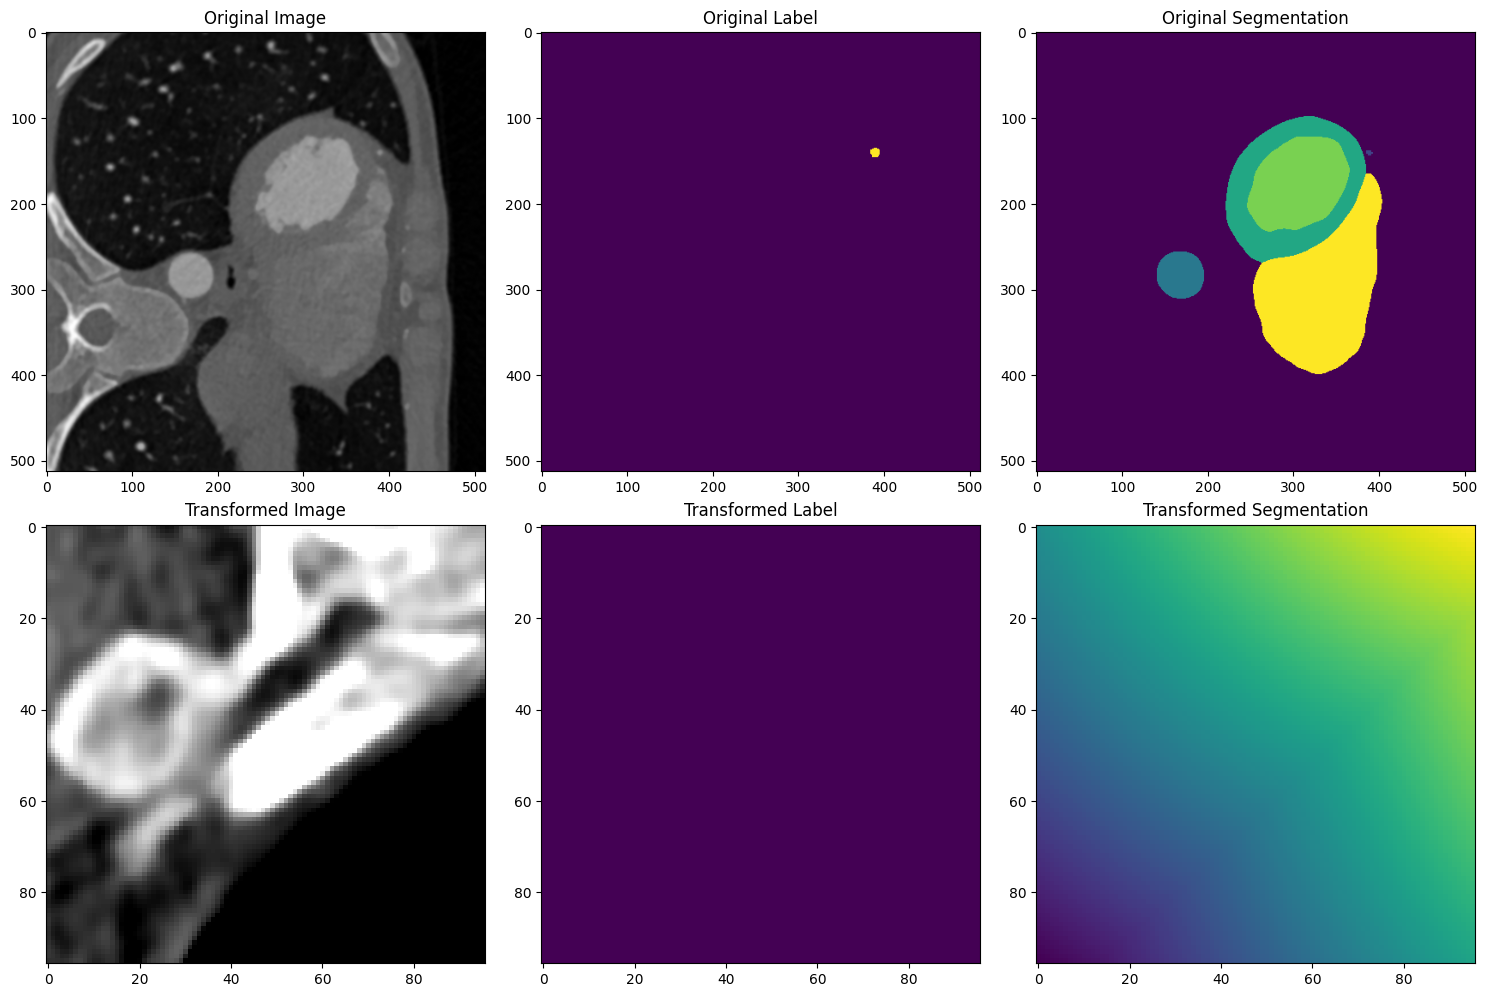


Analyze Distance Map Result:
Shape: torch.Size([4, 8, 96, 96, 96])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     | -209.6402  |  -76.4788  | -142.0556  |  27.1574  
   1     |  135.8713  |  279.7374  |  205.7802  |  26.9465  
   2     |  77.8267   |  211.0877  |  146.0771  |  27.5764  
   3     |  133.2066  |  275.7336  |  204.6042  |  27.5324  
   4     |  156.5407  |  295.5571  |  226.4458  |  27.5390  
   5     |  146.7106  |  291.6265  |  218.9180  |  27.5674  
   6     |  92.9139   |  228.7378  |  159.3762  |  27.3603  
   7     |  115.0174  |  239.1359  |  174.2485  |  27.3836  
------------------------------------------------------------


In [148]:
case_dir = "data/imageCAS/test/790"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=train_transforms)

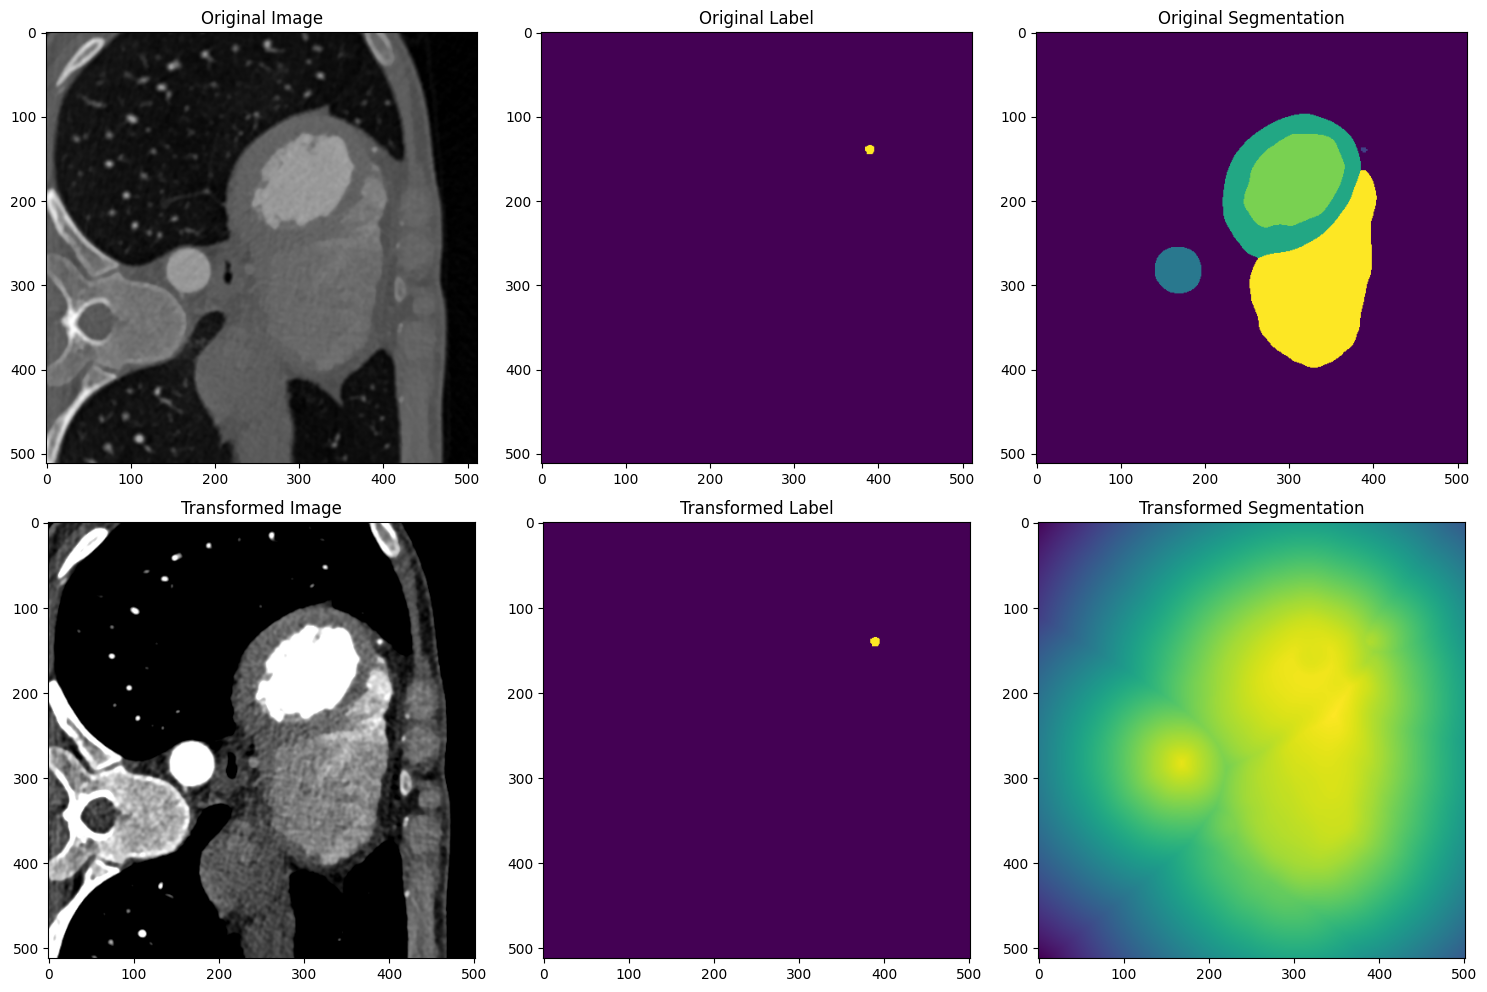


Analyze Distance Map Result:
Shape: torch.Size([1, 8, 512, 501, 275])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     | -276.0580  |  82.7345   |  -69.2250  |  61.8576  
   1     |  -2.8284   |  329.1595  |  115.2145  |  58.5534  
   2     |  -32.4962  |  384.6310  |  143.4577  |  71.9734  
   3     |  -15.6205  |  335.6665  |  116.7874  |  69.0712  
   4     |  -62.8729  |  360.1028  |  133.4326  |  73.3065  
   5     |  -52.0192  |  386.0117  |  129.4066  |  84.1378  
   6     |  -37.5366  |  397.0730  |  164.7632  |  72.6675  
   7     |  -41.6293  |  424.7964  |  173.2838  |  92.7978  
------------------------------------------------------------


In [149]:
case_dir = "data/imageCAS/test/790"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=val_transforms)

### Clipping and Normalization

In [162]:
clip_value = 30.0

In [163]:
def analyze_label_distance_coverage(heart_seg, label):
    results = []
    
    for c in range(heart_seg.shape[0]):
        # Create distance map for heart segmentation
        sitk_mask = sitk.GetImageFromArray(heart_seg[c].numpy())
        sitk_mask = sitk.Cast(sitk_mask, sitk.sitkUInt8)
        
        distance_map = sitk.SignedMaurerDistanceMap(
            sitk_mask,
            insideIsPositive=False,
            squaredDistance=False,
            useImageSpacing=True
        )
        
        distance_map_array = sitk.GetArrayFromImage(distance_map)
        
        # Extract distance values at label positions
        label_points = label.numpy() > 0
        distances_at_labels = distance_map_array[label_points]
        
        # Percentage of label points within the clipping range
        within_range = np.logical_and(
            distances_at_labels >= -clip_value,
            distances_at_labels <= clip_value
        )
        coverage_percent = np.mean(within_range) * 100
        
        channel_result = {
            'channel': c,
            'min_dist': np.min(distances_at_labels),
            'max_dist': np.max(distances_at_labels),
            'mean_dist': np.mean(distances_at_labels),
            'median_dist': np.median(distances_at_labels),
            'coverage_percent': coverage_percent,
            'out_of_range_count': np.sum(~within_range),
            'total_label_points': len(distances_at_labels)
        }
        results.append(channel_result)
    
    print(f"\nLabel Points Distance Statistics (Clipping Range: {-clip_value}~{clip_value} mm)")
    print("-" * 90)
    print(f"{'Channel':^8} | {'Min(mm)':^10} | {'Max(mm)':^10} | {'Mean(mm)':^10} | {'Median(mm)':^10} | {'Coverage(%)':^13} | {'OutOfRange':^10}")
    print("-" * 90)
    
    for result in results:
        print(f"{result['channel']:^8} | "
              f"{result['min_dist']:^10.2f} | "
              f"{result['max_dist']:^10.2f} | "
              f"{result['mean_dist']:^10.2f} | "
              f"{result['median_dist']:^10.2f} | "
              f"{result['coverage_percent']:^13.2f} | "
              f"{result['out_of_range_count']:^10}")
    
    print("-" * 90)
    return results

In [164]:
def create_distance_map(binary_mask):
    distance_maps = []
    
    for c in range(binary_mask.shape[0]):  # each channel
        channel_mask = binary_mask[c].numpy()  # [H, W, D]
        
        # convert to SimpleITK image
        sitk_mask = sitk.GetImageFromArray(channel_mask)
        sitk_mask = sitk.Cast(sitk_mask, sitk.sitkUInt8)
        
        # create distance map
        distance_map = sitk.SignedMaurerDistanceMap(
            sitk_mask,
            insideIsPositive=False,  # heart outside is positive
            squaredDistance=False,
            useImageSpacing=True     # physical distance (mm)
        )
        
        # convert to tensor
        distance_map_array = sitk.GetArrayFromImage(distance_map)
        distance_map_tensor = torch.from_numpy(distance_map_array)
        
        # clip values between -30 and 30
        distance_map_tensor = torch.clamp(distance_map_tensor, min=-clip_value, max=clip_value)
        
        # normalize to [-1, 1] range
        distance_map_tensor = distance_map_tensor / clip_value
        
        distance_maps.append(distance_map_tensor)
    
    return torch.stack(distance_maps)

def ConvertDistanceMap(data):
    seg = data["seg"]  # [C, H, W, D] one-hot encoded segmentation
    
    distance_map = create_distance_map(seg)

    # Analyze label coverage for all channels
    analyze_label_distance_coverage(seg, data["label"][0])
    
    data["seg"] = distance_map
    return data

In [165]:
transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map 
if use_distance_map:
    transforms.append(Lambda(ConvertDistanceMap))

transforms.extend([
    RandCropByPosNegLabeld(
        keys=["image", "label", "seg"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[0],
        prob=0.10,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[1],
        prob=0.10,
    ),
])

if not use_distance_map:
    transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

transforms.append(RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5))

val_transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map
if use_distance_map:
    val_transforms.append(Lambda(ConvertDistanceMap))

if not use_distance_map:
    val_transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

val_transforms = Compose(val_transforms)

train_transforms = Compose(transforms)
val_transforms = Compose(val_transforms)


Label Points Distance Statistics (Clipping Range: -30.0~30.0 mm)
------------------------------------------------------------------------------------------
Channel  |  Min(mm)   |  Max(mm)   |  Mean(mm)  | Median(mm) |  Coverage(%)  | OutOfRange
------------------------------------------------------------------------------------------
   0     |   -20.86   |   11.79    |   -0.68    |    0.00    |    100.00     |     0     
   1     |   -2.83    |   74.10    |    7.41    |    1.41    |     91.05     |   10561   
   2     |    1.00    |   204.13   |   80.89    |   67.31    |     18.34     |   96388   
   3     |   -9.43    |   131.65   |   29.89    |   10.05    |     68.18     |   37560   
   4     |    8.31    |   147.25   |   45.52    |   26.87    |     60.91     |   46140   
   5     |   -0.00    |   154.05   |   46.95    |   29.07    |     51.24     |   57559   
   6     |    1.73    |   213.81   |   83.84    |   79.72    |     19.55     |   94965   
   7     |   -3.00    |   225.05

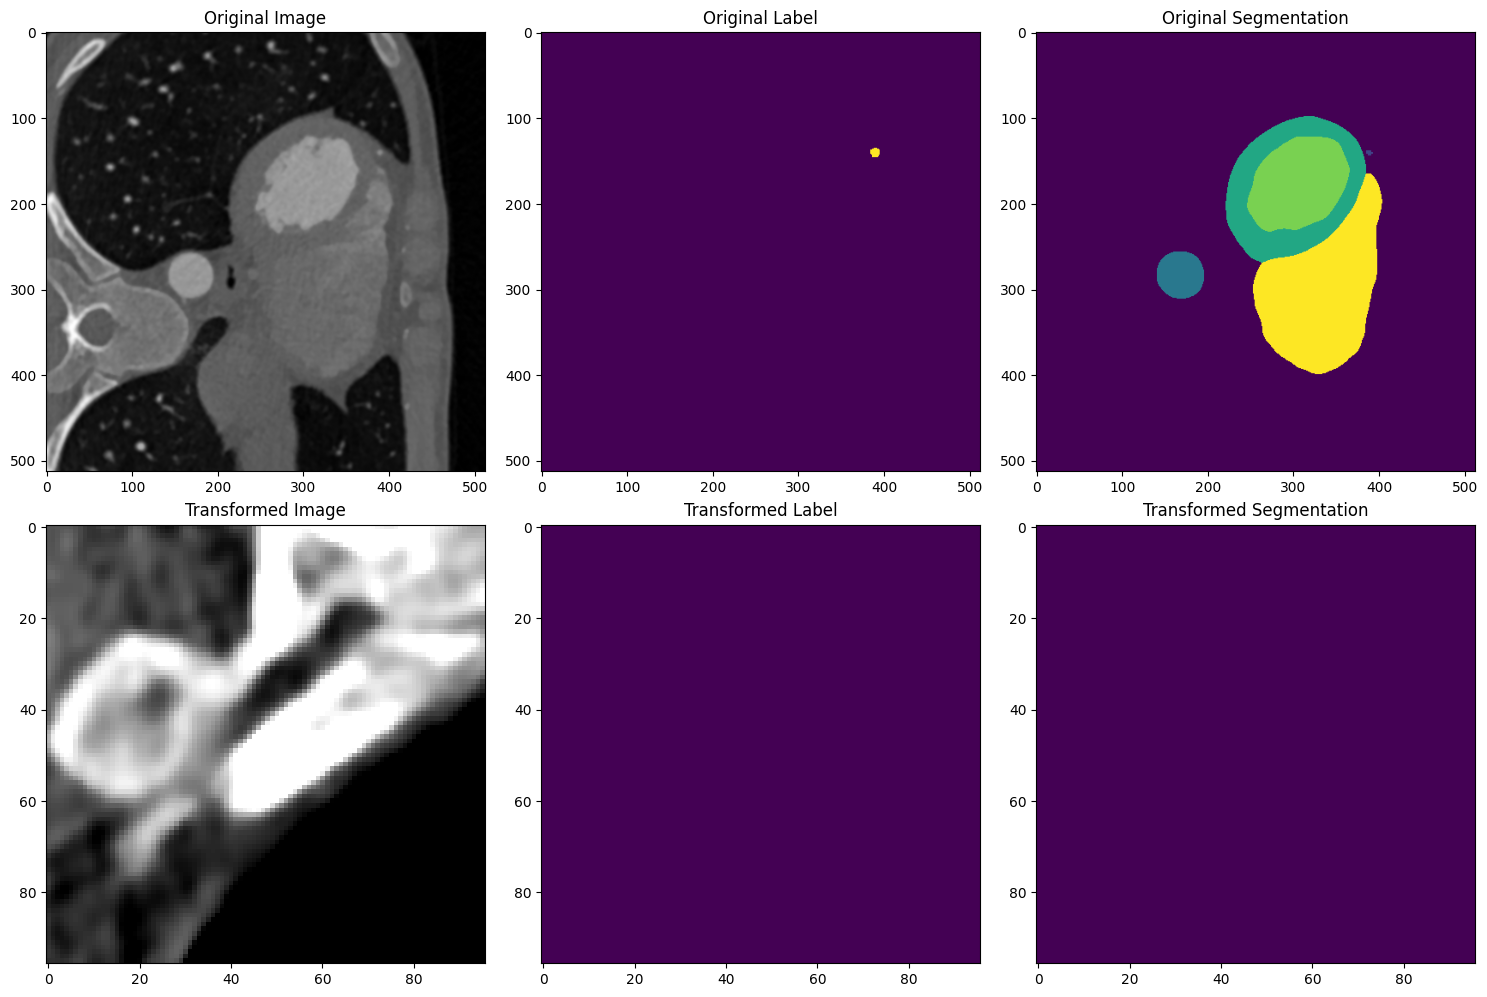


Analyze Distance Map Result:
Shape: torch.Size([4, 8, 96, 96, 96])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     |  -1.0000   |  -1.0000   |  -1.0000   |   0.0000  
   1     |   1.0000   |   1.0000   |   1.0000   |   0.0000  
   2     |   1.0000   |   1.0000   |   1.0000   |   0.0000  
   3     |   1.0000   |   1.0000   |   1.0000   |   0.0000  
   4     |   1.0000   |   1.0000   |   1.0000   |   0.0000  
   5     |   1.0000   |   1.0000   |   1.0000   |   0.0000  
   6     |   1.0000   |   1.0000   |   1.0000   |   0.0000  
   7     |   1.0000   |   1.0000   |   1.0000   |   0.0000  
------------------------------------------------------------


In [166]:
case_dir = "data/imageCAS/test/790"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=train_transforms)


Label Points Distance Statistics (Clipping Range: -30.0~30.0 mm)
------------------------------------------------------------------------------------------
Channel  |  Min(mm)   |  Max(mm)   |  Mean(mm)  | Median(mm) |  Coverage(%)  | OutOfRange
------------------------------------------------------------------------------------------
   0     |   -20.86   |   11.79    |   -0.68    |    0.00    |    100.00     |     0     
   1     |   -2.83    |   74.10    |    7.41    |    1.41    |     91.05     |   10561   
   2     |    1.00    |   204.13   |   80.89    |   67.31    |     18.34     |   96388   
   3     |   -9.43    |   131.65   |   29.89    |   10.05    |     68.18     |   37560   
   4     |    8.31    |   147.25   |   45.52    |   26.87    |     60.91     |   46140   
   5     |   -0.00    |   154.05   |   46.95    |   29.07    |     51.24     |   57559   
   6     |    1.73    |   213.81   |   83.84    |   79.72    |     19.55     |   94965   
   7     |   -3.00    |   225.05

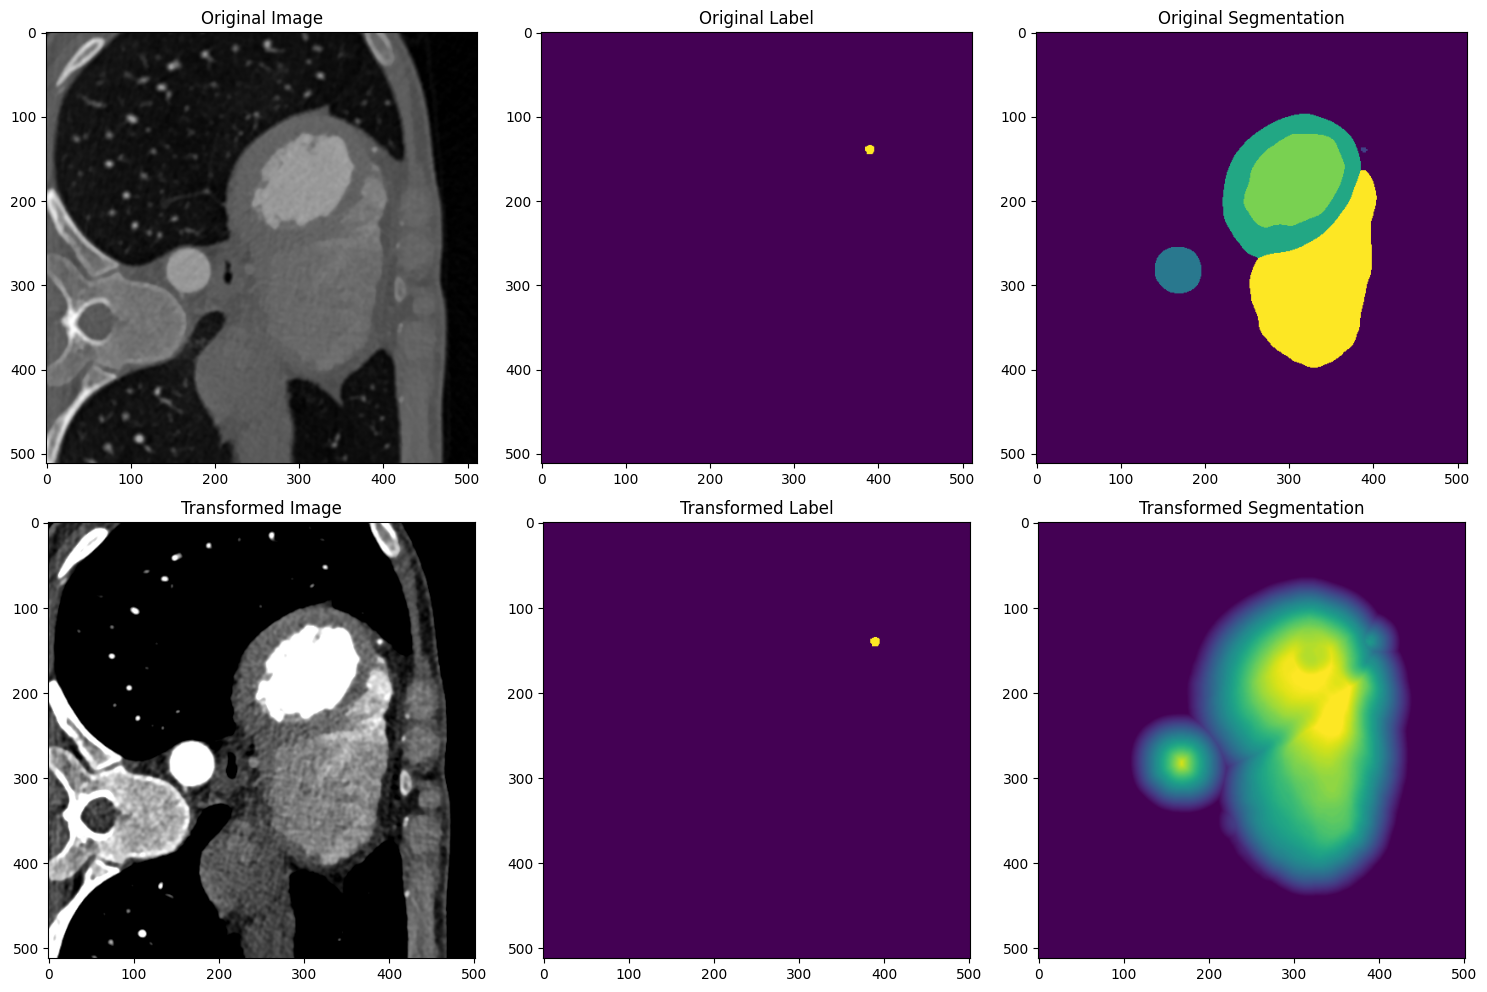


Analyze Distance Map Result:
Shape: torch.Size([1, 8, 512, 501, 275])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     |  -1.0000   |   1.0000   |  -0.7038   |   0.5677  
   1     |  -0.0943   |   1.0000   |   0.9802   |   0.1028  
   2     |  -1.0000   |   1.0000   |   0.9627   |   0.1818  
   3     |  -0.5207   |   1.0000   |   0.9258   |   0.2384  
   4     |  -1.0000   |   1.0000   |   0.9300   |   0.2875  
   5     |  -1.0000   |   1.0000   |   0.9102   |   0.3074  
   6     |  -1.0000   |   1.0000   |   0.9715   |   0.1707  
   7     |  -1.0000   |   1.0000   |   0.9637   |   0.1931  
------------------------------------------------------------


In [167]:
case_dir = "data/imageCAS/test/790"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=val_transforms)

### 3D Visualization

In [219]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

In [280]:
def visualize_all_channels_3d(distance_map, step=4):
    """
    모든 채널의 3D distance map을 하나의 그래프에 시각화합니다.
    Distance 값에 따라 색상이 변화합니다 (-0.5: 파랑 -> 0: 초록 -> 0.5: 빨강)
    """
    
    # 브라우저에서 열도록 설정
    pio.renderers.default = "browser"
    
    # 전체 데이터 shape 출력
    print("Distance Map Shape:", distance_map.shape)
    
    # 커스텀 컬러스케일 정의 (-0.5 ~ 0.5 범위에 대해)
    custom_colorscale = [
        [0.0, 'red'],       # -0.5
        [0.25, 'orange'],     # -0.25
        [0.5, 'yellow'],     # 0
        [0.75, 'green'],    # 0.25
        [1.0, 'blue']         # 0.5
    ]
    
    # 3D scatter plot 생성
    fig = go.Figure()
    
    for channel in range(distance_map.shape[0]):
        # 현재 채널의 데이터 추출
        channel_data = distance_map[channel].numpy()
        
        # 각 축의 좌표값 생성
        x_coords = range(channel_data.shape[0])
        y_coords = range(channel_data.shape[1])
        z_coords = range(channel_data.shape[2])
        
        # meshgrid로 3D 좌표 생성
        X, Y, Z = np.meshgrid(x_coords[::step], y_coords[::step], z_coords[::step], indexing='ij')
        
        # distance 값 추출
        distances = channel_data[::step, ::step, ::step]
        
        # 마스크 생성 (threshold 값 이하인 점들만 표시)
        mask = np.abs(distances) < 0.5
        
        # 현재 채널의 scatter plot 추가
        fig.add_trace(
            go.Scatter3d(
                x=X[mask],
                y=Y[mask],
                z=Z[mask],
                mode='markers',
                showlegend=False,
                marker=dict(
                    size=2,
                    color=distances[mask],
                    colorscale=custom_colorscale,
                    cmin=-0.5,  # 색상 범위 최소값을 -0.5로 설정
                    cmax=0.5,   # 색상 범위 최대값을 0.5로 설정
                    colorbar=dict(
                        title=dict(
                            text='Distance',
                            side='right'
                        )
                    ),
                    opacity=0.2
                )
            )
        )
        
        print(f"Channel {channel} points:", np.sum(mask))
    
    # 레이아웃 설정 (이전과 동일)
    fig.update_layout(
        title='Distance Map 3D Visualization - All Channels',
        scene=dict(
            xaxis=dict(
                showbackground=False,
                showgrid=False,
                zeroline=False,
                showline=False,
                showticklabels=False,
                showaxeslabels=False,
                title=''
            ),
            yaxis=dict(
                showbackground=False,
                showgrid=False,
                zeroline=False,
                showline=False,
                showticklabels=False,
                showaxeslabels=False,
                title=''
            ),
            zaxis=dict(
                showbackground=False,
                showgrid=False,
                zeroline=False,
                showline=False,
                showticklabels=False,
                showaxeslabels=False,
                title=''
            ),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.2)
            ),
            aspectmode='data',
            bgcolor='rgba(0,0,0,0)'
        ),
        width=1200,
        height=1000,
        showlegend=False,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    
    fig.show()

In [239]:
def create_distance_map(binary_mask):
    distance_maps = []
    
    for c in range(binary_mask.shape[0]):  # each channel
        channel_mask = binary_mask[c].numpy()  # [H, W, D]
        
        # convert to SimpleITK image
        sitk_mask = sitk.GetImageFromArray(channel_mask)
        sitk_mask = sitk.Cast(sitk_mask, sitk.sitkUInt8)
        
        # create distance map
        distance_map = sitk.SignedMaurerDistanceMap(
            sitk_mask,
            insideIsPositive=False,  # heart outside is positive
            squaredDistance=False,
            useImageSpacing=True     # physical distance (mm)
        )
        
        # convert to tensor
        distance_map_array = sitk.GetArrayFromImage(distance_map)
        distance_map_tensor = torch.from_numpy(distance_map_array)
        
        # clip values between -30 and 30
        distance_map_tensor = torch.clamp(distance_map_tensor, min=-clip_value, max=clip_value)
        
        # normalize to [-1, 1] range
        distance_map_tensor = distance_map_tensor / clip_value
        
        distance_maps.append(distance_map_tensor)
    
    return torch.stack(distance_maps)

def ConvertDistanceMap(data):
    seg = data["seg"]  # [C, H, W, D] one-hot encoded segmentation
    
    distance_map = create_distance_map(seg)

    data["seg"] = distance_map
    return data

In [240]:
transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map 
if use_distance_map:
    transforms.append(Lambda(ConvertDistanceMap))

transforms.extend([
    RandCropByPosNegLabeld(
        keys=["image", "label", "seg"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[0],
        prob=0.10,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[1],
        prob=0.10,
    ),
])

if not use_distance_map:
    transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

transforms.append(RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5))

val_transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map
if use_distance_map:
    val_transforms.append(Lambda(ConvertDistanceMap))

if not use_distance_map:
    val_transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

val_transforms = Compose(val_transforms)

train_transforms = Compose(transforms)
val_transforms = Compose(val_transforms)

c:\SEOA\virtual\coronary-artery\.venv\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning:

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.



In [241]:
case_dir = "data/imageCAS/test/790"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")

data_dict = [{"image": image_path, "label": label_path, "seg": seg_path}]
    
basic_transforms = Compose([
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
])
    
basic_ds = Dataset(data=data_dict, transform=basic_transforms)
full_ds = Dataset(data=data_dict, transform=val_transforms)
    
basic_data = first(DataLoader(basic_ds, batch_size=1))
full_data = first(DataLoader(full_ds, batch_size=1))

In [281]:
full_data["seg"] = full_data["seg"].squeeze(0)
visualize_all_channels_3d(full_data["seg"])

Distance Map Shape: torch.Size([8, 512, 501, 275])
Channel 0 points: 158315
Channel 1 points: 17823
Channel 2 points: 33237
Channel 3 points: 76926
Channel 4 points: 42968
Channel 5 points: 65037
Channel 6 points: 22250
Channel 7 points: 27820


In [248]:
def save_distance_map_as_nifti(distance_map, save_folder, reference_path, filename_prefix="distance_map"):
    """
    Distance map을 NIfTI 파일로 저장합니다.
    
    Args:
        distance_map: shape [C, H, W, D]의 distance map tensor
        save_folder: 저장할 폴더 경로
        reference_path: 원본 이미지 경로 (메타 정보를 가져올 NIfTI 파일)
        filename_prefix: 저장할 파일 이름 접두사
    """
    # 저장 폴더 생성
    os.makedirs(save_folder, exist_ok=True)
    
    # 원본 이미지에서 메타 정보 가져오기
    ref_img = nib.load(reference_path)
    affine = ref_img.affine
    header = ref_img.header.copy()
    
    # numpy array로 변환
    distance_map_np = distance_map.detach().cpu().numpy()
    
    # 채널별로 저장
    for c in range(distance_map_np.shape[0]):
        # 현재 채널의 distance map
        channel_map = distance_map_np[c]
        
        # NIfTI 이미지 생성 (원본 affine matrix와 header 사용)
        nifti_img = nib.Nifti1Image(channel_map, affine, header)
        
        # 데이터 타입 설정 (float32로 통일)
        nifti_img.set_data_dtype(np.float32)
        
        # 추가 메타데이터 설정
        header = nifti_img.header
        header['descrip'] = f'Distance Map Channel {c}'  # 설명 추가
        
        # 파일 저장
        output_path = os.path.join(save_folder, f"{filename_prefix}_channel_{c}.nii.gz")
        nib.save(nifti_img, output_path)
        print(f"Saved channel {c} to: {output_path}")
        print(f"Using affine matrix:\n{affine}")
        print(f"Pixel dimensions: {header.get_zooms()}")

# 사용 예시:
save_folder = "./output/distance_maps"
image_path = "./data/imageCAS/test/790/img.nii.gz"
save_distance_map_as_nifti(
    distance_map=full_data["seg"],
    save_folder=save_folder,
    reference_path=image_path,  # 원본 이미지 경로
    filename_prefix="distance_map"
)

Saved channel 0 to: ./output/distance_maps\distance_map_channel_0.nii.gz
Using affine matrix:
[[0.34999999 0.         0.         0.        ]
 [0.         0.34999999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         1.        ]]
Pixel dimensions: (0.35, 0.35, 0.5)
Saved channel 1 to: ./output/distance_maps\distance_map_channel_1.nii.gz
Using affine matrix:
[[0.34999999 0.         0.         0.        ]
 [0.         0.34999999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         1.        ]]
Pixel dimensions: (0.35, 0.35, 0.5)
Saved channel 2 to: ./output/distance_maps\distance_map_channel_2.nii.gz
Using affine matrix:
[[0.34999999 0.         0.         0.        ]
 [0.         0.34999999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         1.        ]]
Pixel dimensions: (0.35, 0.35, 0.5)
Saved channel 3 to: ./output/distance_maps\

## Transforms in Proposed Dataloader with MONAI

In [104]:
import autorootcwd
import monai
from monai.utils import first, set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandFlipd,
    CropForegroundd,
    Compose,
    Spacingd,
    AsDiscreted,
    GaussianSmoothd,
    Lambda,
    DistanceTransformEDTd, DistanceTransformEDT,
    ToTensord,
)
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import SimpleITK as sitk
import os
import torch
import numpy as np
import pytorch_lightning as pl
from pathlib import Path
import matplotlib.pyplot as plt
import cucim

print(cucim.__version__)
from monai.transforms import DistanceTransformEDTd
print(DistanceTransformEDTd.__module__)
print(DistanceTransformEDTd.__doc__)

23.10.00
monai.transforms.post.dictionary

    Applies the Euclidean distance transform on the input.
    Either GPU based with CuPy / cuCIM or CPU based with scipy.
    To use the GPU implementation, make sure cuCIM is available and that the data is a `torch.tensor` on a GPU device.

    Note that the results of the libraries can differ, so stick to one if possible.
    For details, check out the `SciPy`_ and `cuCIM`_ documentation and / or :func:`monai.transforms.utils.distance_transform_edt`.


    Note on the input shape:
        Has to be a channel first array, must have shape: (num_channels, H, W [,D]).
        Can be of any type but will be converted into binary: 1 wherever image equates to True, 0 elsewhere.
        Input gets passed channel-wise to the distance-transform, thus results from this function will differ
        from directly calling ``distance_transform_edt()`` in CuPy or SciPy.

    Args:
        keys: keys of the corresponding items to be transformed.
        all

In [106]:
use_distance_map = True

In [ ]:
transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map 
if use_distance_map:
    transforms.append(
        DistanceTransformEDTd(keys=["seg"])
    )

transforms.extend([
    RandCropByPosNegLabeld(
        keys=["image", "label", "seg"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[0],
        prob=0.10,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[1],
        prob=0.10,
    ),
])

if not use_distance_map:
    transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

transforms.append(RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5))

val_transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map
if use_distance_map:
    val_transforms.append(DistanceTransformEDTd(keys=["seg"]))

if not use_distance_map:
    val_transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

val_transforms = Compose(val_transforms)

train_transforms = Compose(transforms)
val_transforms = Compose(val_transforms)

In [66]:
def visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=train_transforms):
    """visualize the before/after transforms for a specific image."""
    
    data_dict = [{"image": image_path, "label": label_path, "seg": seg_path}]
    
    basic_transforms = Compose([
        LoadImaged(keys=["image", "label", "seg"]),
        EnsureChannelFirstd(keys=["image", "label", "seg"]),
    ])
    
    basic_ds = Dataset(data=data_dict, transform=basic_transforms)
    full_ds = Dataset(data=data_dict, transform=transform)
    
    basic_data = first(DataLoader(basic_ds, batch_size=1))
    full_data = first(DataLoader(full_ds, batch_size=1))
    
    # === 여기서 device 정보 출력 ===
    print("Transformed seg device:", full_data["seg"].device)
    print("Transformed image device:", full_data["image"].device)
    # =============================
    
    plt.figure("Transforms Visualization", (15, 10))
    
    # Original Data (First Row)
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(basic_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 3, 2)
    plt.title("Original Label")
    plt.imshow(basic_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 3)
    plt.title("Original Segmentation")
    plt.imshow(basic_data["seg"][0, 0, :, :, slice_idx])
    
    # Transformed Data (Second Row)
    plt.subplot(2, 3, 4)
    plt.title("Transformed Image")
    plt.imshow(full_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 3, 5)
    plt.title("Transformed Label")
    plt.imshow(full_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 6)
    plt.title("Transformed Segmentation")
    plt.imshow(full_data["seg"][0, 0, :, :, slice_idx].cpu())
    # if full_data["seg"].shape[1] > 1:  # if one-hot encoded or distance map
    #     # Combine all channels for visualization
    #     seg_vis = np.sum(full_data["seg"][0, :, :, :, slice_idx], axis=0)
    #     plt.imshow(seg_vis)
    # else:
    #     plt.imshow(full_data["seg"][0, 0, :, :, slice_idx])
    
    plt.tight_layout()
    plt.show()
   

Transformed seg device: cuda:0
Transformed image device: cpu


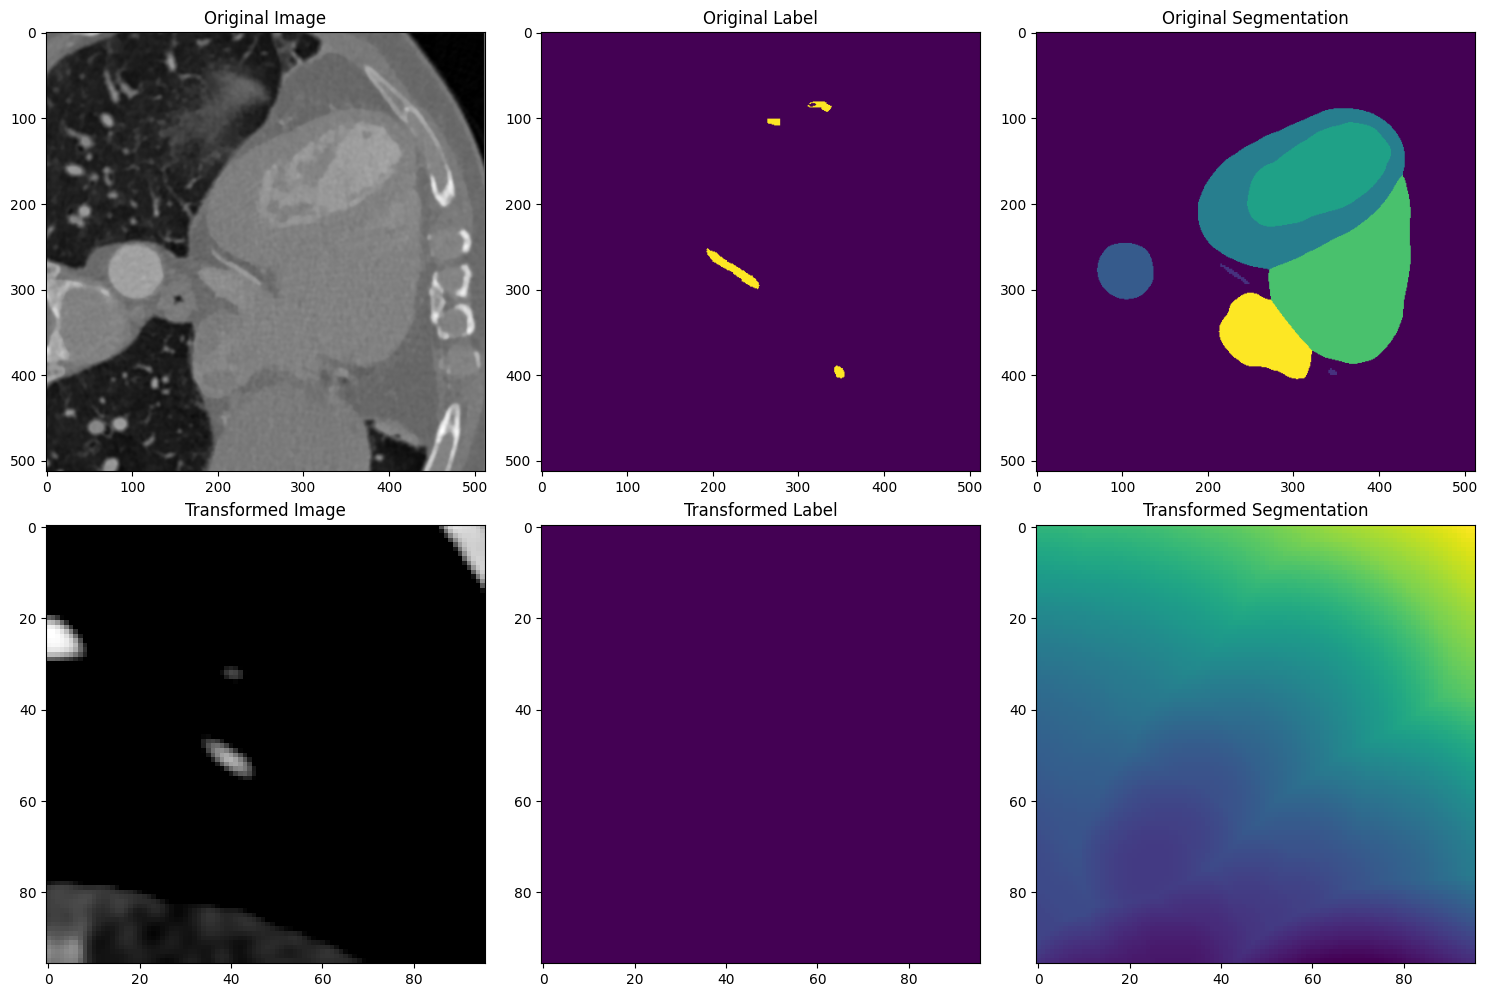

In [67]:
case_dir = "data/imageCAS_heart/test/1000"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=train_transforms)

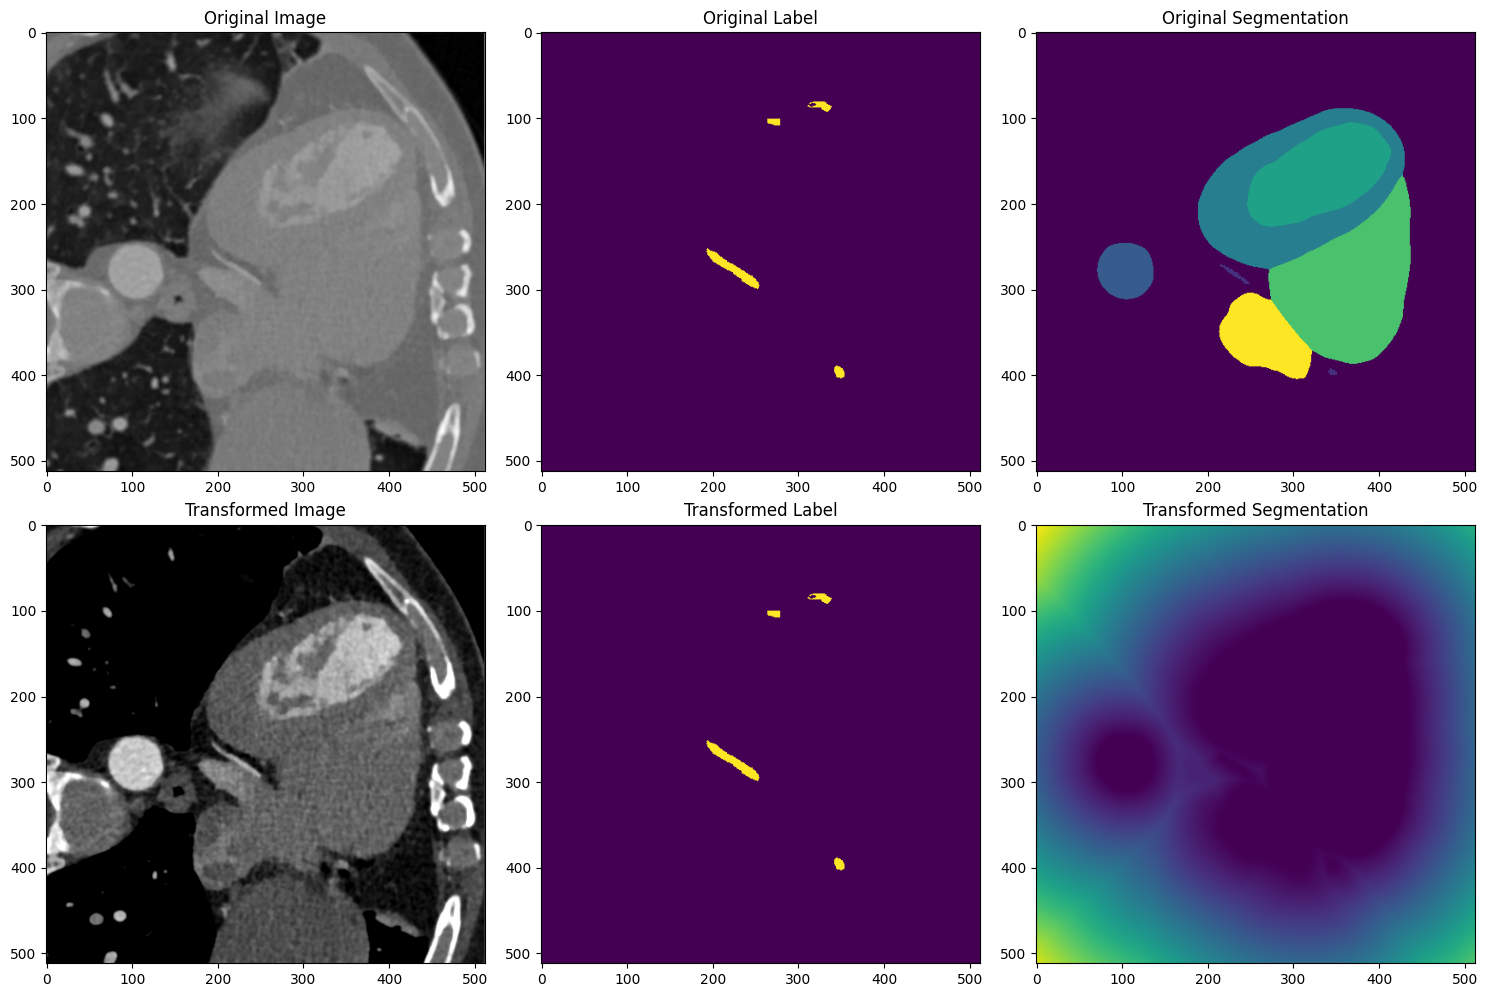

In [24]:
case_dir = "data/imageCAS_heart/test/1000"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=val_transforms)

In [216]:
import time
import torch

# 예시: [C, H, W, D] shape의 one-hot mask
mask = torch.randint(0, 2, (8, 256, 256, 256)).float()

from monai.transforms import DistanceTransformEDT

distance_transform = DistanceTransformEDT()

# CPU에서 시간 측정
start = time.time()
result_cpu = distance_transform(mask)
print("CPU time:", time.time() - start)

# GPU에서 시간 측정
mask_cuda = mask.cuda()
torch.cuda.synchronize()
start = time.time()
result_gpu = distance_transform(mask_cuda)
torch.cuda.synchronize()
print("GPU time:", time.time() - start)

KeyboardInterrupt: 